In [1]:
import numpy as np
import h5py
import os
from collections import namedtuple

from matplotlib import pyplot as plt
from matplotlib import lines, colors, ticker
import seaborn as sns
import pandas as pd

In [2]:
import sys
sys.path.append('../externals/gfz_cygnss/')

In [3]:
import torch
import pytorch_lightning as pl

/home/k/k202141/.conda/envs/cygnss-d/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from gfz_202003.training.cygnssnet import CyGNSSDataModule, ImageNet
import gfz_202003.utils.mathematics as mat

## Preparation

In [5]:
# path to test data
test_data_path = '/work/ka1176/shared_data/2022-cygnss-deployment/small_data/'

In [6]:
# saved model
path = '/work/ka1176/shared_data/2022-cygnss-deployment/cygnss_trained_model/ygambdos_yykDM/trained_model/checkpoint/'
model = 'cygnssnet-epoch=0.ckpt'
checkpoint = torch.load(os.path.join(path, model),
                       map_location=torch.device("cpu"))

In [7]:
# change data path
checkpoint['hyper_parameters']["data"] = test_data_path

In [8]:
args = namedtuple("ObjectName", checkpoint['hyper_parameters'].keys())(*checkpoint['hyper_parameters'].values())

In [9]:
# dataset
cdm = CyGNSSDataModule(args)
cdm.setup(stage='test')
input_shapes = cdm.get_input_shapes(stage='test')

# data loader
test_loader = cdm.test_dataloader()


timestamp of test data: 2021-10-19 09:45:33.788647
loading test data into memory...
normalizing test data
* brcs after normalization: mean=1.91e-01 / std = 1.27e+00
* eff_scatter after normalization: mean=1.69e-01 / std = 1.28e+00
* power_analog after normalization: mean=-1.82e-01 / std = 6.05e-01
* raw_counts after normalization: mean=-3.20e-01 / std = 5.89e-01
* ddm_nbrcs after normalization: mean=2.08e-01 / std = 9.65e-01
* ddm_les after normalization: mean=2.13e-01 / std = 9.04e-01
* gps_eirp after normalization: mean=-5.66e-01 / std = 4.81e-01
* lna_temp_nadir_port after normalization: mean=1.70e+00 / std = 6.44e-01
* lna_temp_nadir_starboard after normalization: mean=1.45e+00 / std = 6.16e-01
* lna_temp_zenith after normalization: mean=1.04e+00 / std = 8.77e-01
* sc_roll after normalization: mean=-5.86e-01 / std = 5.58e-02
* sc_yaw after normalization: mean=-1.50e+00 / std = 2.49e+00
* sp_az_body after normalization: mean=-2.05e-01 / std = 9.20e-01
* sp_az_orbit after normalizat

In [10]:
class CyGNSSNet(pl.LightningModule):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        #self.save_hyperparameters(self.backbone.args)
        self.best_loss = np.inf # reported for nni
        self.best_epoch = 0

    def forward(self, x):
        y = self.backbone(x)
        return y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.backbone(x)
        y_pred = torch.squeeze(y_pred, dim=1)
        loss = self.backbone.loss(y_pred, y)
#        self.log('train_loss', loss, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.backbone(x)
        y_pred = torch.squeeze(y_pred, dim=1)
        loss = self.backbone.loss(y_pred, y)
        self.log('valid_loss', loss, on_epoch=True)
        return loss

    def validation_epoch_end(self, outputs):
        val_loss = self.trainer.callback_metrics["valid_loss"]
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_epoch = self.trainer.current_epoch
        self.log('best_loss', self.best_loss)
        self.log('best_epoch', self.best_epoch)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.backbone(x)
        y_pred = torch.squeeze(y_pred, dim=1)
        loss = self.backbone.loss(y_pred, y)
        self.log('test_loss', loss)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.backbone(x)
        y_pred = torch.squeeze(y_pred, dim=1)
        return y_pred

    def configure_optimizers(self):
        if self.backbone.args.optimizer=='adam':
            return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        elif self.backbone.args.optimizer=='sgd':
            return torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)

    @staticmethod
    def activation_fn(activation_name):
        if activation_name == 'tanh':
            return torch.tanh
        elif activation_name == 'relu':
            return F.relu
        elif activation_name == 'sigmoid':
            return torch.sigmoid
        elif activation_name == 'leaky_relu':
            return F.leaky_relu

    @staticmethod
    def loss_fn(loss_name):
        if loss_name == 'mse':
            return F.mse_loss
        elif loss_name == 'mae':
            return F.l1_loss

    @staticmethod
    def best_checkpoint_path(save_model_path, best_epoch):
        '''Path to best checkpoint'''
        ckpt_path = os.path.join(os.path.dirname(save_model_path), 'checkpoint', f"cygnssnet-epoch={best_epoch}.ckpt")
        all_ckpts = os.listdir(os.path.dirname(ckpt_path))
        # If the checkpoint already exists, lightning creates "*-v1.ckpt"
        only_ckpt = ~np.any([f'-v{best_epoch}' in ckpt for ckpt in all_ckpts])
        assert only_ckpt, f'Cannot load checkpoint: found versioned checkpoints for best_epoch {best_epoch} in {os.path.dirname(ckpt_path)}'
        return ckpt_path


In [11]:
# load model state from checkpoint
backbone = ImageNet(args, input_shapes)
model = CyGNSSNet(backbone)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# generate predictions
trainer = pl.Trainer(num_sanity_val_steps=0, 
                             gpus=int(torch.cuda.is_available()),
                             enable_progress_bar=False)
y_pred = trainer.predict(model=model, dataloaders=[test_loader])
y_pred = torch.cat(y_pred).detach().cpu().numpy().squeeze()


/home/k/k202141/.conda/envs/cygnss-d/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
y_pred

array([8.037451 , 9.155466 , 6.4046926, ..., 6.3773756, 6.0596523,
       6.4005737], dtype=float32)

In [13]:
# additional parameters that should be saved

In [14]:
y_true = test_loader.dataset.y

In [15]:
# spatiotemporal information is unfortunately not part of the dataset and may thus be harder to obtain
col_idx = checkpoint["hyper_parameters"]["v_par_eval"].index('ddm_timestamp_utc')
ddm_timestamp_utc = test_loader.dataset.v_par_eval[:, col_idx]

col_idx = checkpoint["hyper_parameters"]["v_par_eval"].index('sp_lat')
sp_lat = test_loader.dataset.v_par_eval[:, col_idx]

col_idx = checkpoint["hyper_parameters"]["v_par_eval"].index('sp_lon')
sp_lon = test_loader.dataset.v_par_eval[:, col_idx]

## Evaluation

Calculate the root mean squared error (RMSE) for different values of the windspeed

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f'Overall root mean square error (RMSE): {rmse:.4f} m/s')

Overall root mean square error (RMSE): 1.0774 m/s


Find the indices for the windspeed bins - below 12 m/s, below 16 m/s, above 16 m/s

In [18]:
y_bins = [4, 8, 12, 16, 20, 100]
y_ix   = np.digitize(y_true, y_bins, right=False)

In [19]:
np.unique(y_ix, return_counts=True) # test data does not contain samples > 16 m/s

(array([0, 1, 2, 3]), array([ 763, 5397, 1543,   26]))

In [20]:
all_rmse = np.zeros(len(y_bins))
all_bias = np.zeros(len(y_bins))
all_counts = np.zeros(len(y_bins))

In [21]:
for i, yy in enumerate(y_bins):
    if np.any(y_ix==i):
        rmse = mean_squared_error(y_true[y_ix==i], y_pred[y_ix==i], squared=False)
        all_rmse[i] = rmse
        all_bias[i] = np.mean(y_pred[y_ix==i] - y_true[y_ix==i])
        all_counts[i] = np.sum(y_ix==i)
        print(f'RMSE in bin {i} (up to {yy} m/s): {rmse:.4f} m/s')
    else:
        all_rmse[i] = None
        all_bias[i] = None
        all_counts[i] = 0
        print(f"--- No samples in bin {i} (up to {yy} m/s)")

RMSE in bin 0 (up to 4 m/s): 1.1389 m/s
RMSE in bin 1 (up to 8 m/s): 0.8988 m/s
RMSE in bin 2 (up to 12 m/s): 1.4499 m/s
RMSE in bin 3 (up to 16 m/s): 3.8104 m/s
--- No samples in bin 4 (up to 20 m/s)
--- No samples in bin 5 (up to 100 m/s)


In [22]:
# store directly in pandas for plotting
df_rmse = pd.DataFrame(dict(rmse=all_rmse, bias=all_bias, bins=y_bins, counts=all_counts))

df_rmse

,rmse,bias,bins,counts
0,1.138855,0.986579,4,763.0
1,0.898850,0.187089,8,5397.0
2,1.449921,-0.897265,12,1543.0
3,3.810419,-3.763522,16,26.0
4,NaN,NaN,20,0.0
5,NaN,NaN,100,0.0


## Plots

In [23]:
sns.set_style('whitegrid')
sns.set_context('talk')

### Scatter plot of predicted vs true windspeed

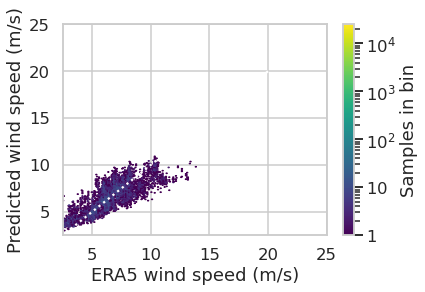

In [24]:
ymin = 2.5
ymax = 25.0

fig=plt.figure()
ax=fig.add_subplot(111)

img=ax.hexbin(y_true, y_pred, cmap='viridis', norm=colors.LogNorm(vmin=1, vmax=25000), mincnt=1)
clb=plt.colorbar(img)
clb.set_ticks([1, 10, 100, 1000, 10000])
clb.set_ticklabels([r'$1$', r'$10$', r'$10^2$', r'$10^3$', r'$10^4$'])
clb.set_label('Samples in bin')
clb.ax.tick_params()

ax.set_xlabel('ERA5 wind speed (m/s)')
ax.set_ylabel('Predicted wind speed (m/s)')

ax.plot(np.linspace(0, 30), np.linspace(0, 30), 'w:')

ax.set_ylim(ymin, 25)
ax.set_xlim(ymin, 25)

ax.set_xticks([5, 10, 15, 20, 25])
ax.set_xticklabels([5, 10, 15, 20, 25])
ax.set_yticks([5, 10, 15, 20, 25])
ax.set_yticklabels([5, 10, 15, 20, 25])

fig.tight_layout()

### Histogram plots

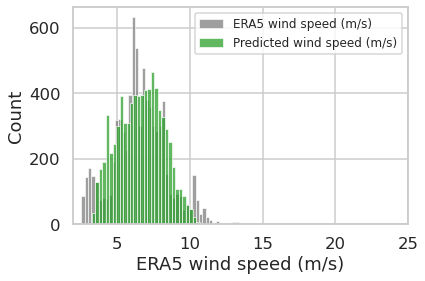

In [25]:
fig=plt.figure()
ax=fig.add_subplot(111)

sns.histplot(y_true, ax=ax, color='C7', label='ERA5 wind speed (m/s)')
sns.histplot(y_pred, ax=ax, color='C2', label='Predicted wind speed (m/s)')

ax.legend(fontsize=12)

ax.set_xticks([5, 10, 15, 20, 25])
ax.set_xticklabels([5, 10, 15, 20, 25])
ax.set_xlabel('ERA5 wind speed (m/s)')

plt.show()

### Cartopy plot

This figure will look more impressive if predictions are gathered from more than one day

In [26]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

In [27]:
deg = 1 # grid resolution (publication: 1)

xx, yy, gridded_y_true = mat.average_to_grid2(sp_lon[:], sp_lat[:], y_true[:], resolution=deg)
xx, yy, gridded_y_pred = mat.average_to_grid2(sp_lon[:], sp_lat[:], y_pred[:], resolution=deg)
xx, yy, gridded_rmse = mat.average_to_grid2(sp_lon[:], sp_lat[:], np.abs(y_pred[:] - y_true[:]), resolution=deg)
xx, yy, gridded_bias = mat.average_to_grid2(sp_lon[:], sp_lat[:], y_pred[:] - y_true[:], resolution=deg)

/home/k/k202141/.conda/envs/cygnss-d/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/k/k202141/.conda/envs/cygnss-d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [28]:
grid_lon = np.arange(-180, 181, deg)
grid_lat = np.arange(-90, 91, deg)

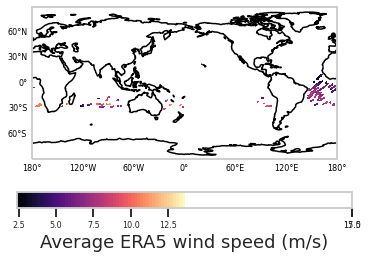

In [29]:
proj = ccrs.PlateCarree(180)
fig, ax = plt.subplots(1, 1, figsize=(6,4), gridspec_kw=dict(hspace=0.05, wspace=0.1), subplot_kw=dict(projection=proj))
cmap = ax.contourf(grid_lon[:], grid_lat[::-1][:], gridded_y_true[:].T, levels=60, transform=proj, antialiased=False, cmap='magma')
ax.coastlines()
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels= False
clb = plt.colorbar(cmap, ax=ax, orientation='horizontal', shrink=1, label='Average ERA5 wind speed (m/s)')

clb.set_ticks(np.arange(2.5, 18, 2.5))
clb.ax.tick_params(labelsize=8)

gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}

plt.show()

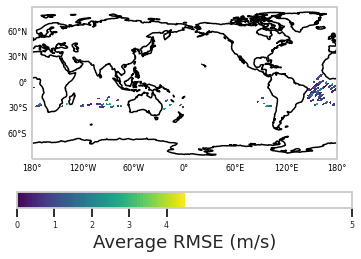

In [30]:
proj = ccrs.PlateCarree(180)
fig, ax = plt.subplots(1, 1, figsize=(6,4), gridspec_kw=dict(hspace=0.05, wspace=0.1), subplot_kw=dict(projection=proj))
cmap = ax.contourf(grid_lon[:], grid_lat[::-1][:], gridded_rmse[:].T, levels=60, transform=proj, antialiased=False, cmap='viridis')
ax.coastlines()
gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels= False
clb = plt.colorbar(cmap, ax=ax, orientation='horizontal', shrink=1, label='Average RMSE (m/s)')

clb.set_ticks(np.arange(0, np.nanmax(gridded_rmse)+1, 1.0))
clb.ax.tick_params(labelsize=8)

gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}

plt.show()

### RMSE over time
This is not really meaningful for a single day, I include it here just for the general idea

In [31]:
# mock up data that represents the long running average rmse
df_rmse["time"] = "today"

df_mockup = pd.DataFrame(dict(bins=y_bins, 
                              rmse=all_rmse + np.random.rand(len(y_bins))-0.5, 
                              bias=all_bias + np.random.rand(len(y_bins))-0.5,
                              counts=all_counts * 1000))
df_mockup["time"] = "long-running average"

df_mockup = pd.concat([df_rmse, df_mockup], ignore_index=True)

df_mockup

,rmse,bias,bins,counts,time
0,1.138855,0.986579,4,763.0,today
1,0.898850,0.187089,8,5397.0,today
2,1.449921,-0.897265,12,1543.0,today
3,3.810419,-3.763522,16,26.0,today
4,NaN,NaN,20,0.0,today
5,NaN,NaN,100,0.0,today
6,1.367458,1.464426,4,763000.0,long-running average
7,1.013613,0.498005,8,5397000.0,long-running average
8,0.951009,-0.969138,12,1543000.0,long-running average
9,4.267776,-3.991577,16,26000.0,long-running average


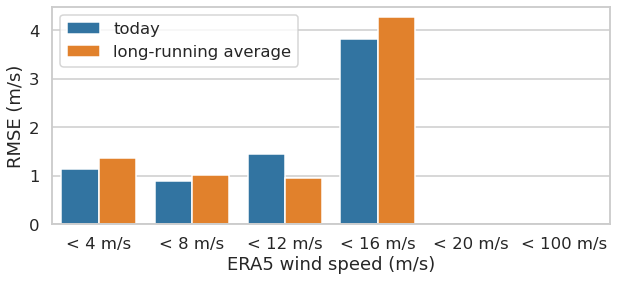

In [32]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)

sns.barplot(data=df_mockup, x='bins', y='rmse', hue='time', ax=ax)
ax.legend()

ax.set_xlabel('ERA5 wind speed (m/s)')
ax.set_ylabel('RMSE (m/s)')

ax.set_xticks(range(len(y_bins)))
ax.set_xticklabels([f'< {yy} m/s' for yy in y_bins])

plt.show()

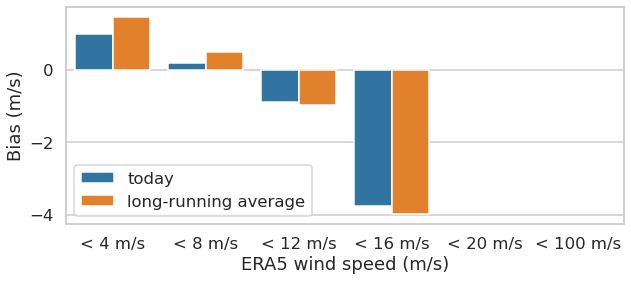

In [33]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)

sns.barplot(data=df_mockup, x='bins', y='bias', hue='time', ax=ax)
ax.legend()

ax.set_xlabel('ERA5 wind speed (m/s)')
ax.set_ylabel('Bias (m/s)')

ax.set_xticks(range(len(y_bins)))
ax.set_xticklabels([f'< {yy} m/s' for yy in y_bins])

plt.show()

### Sample counts

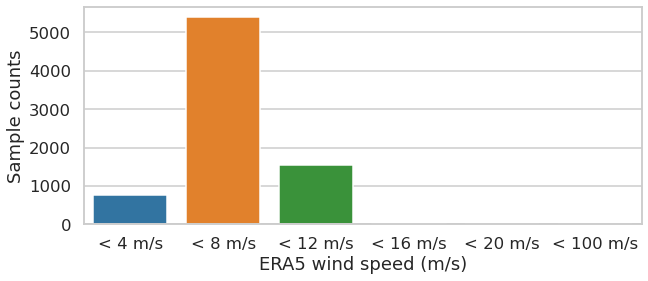

In [34]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
sns.barplot(data=df_rmse, x='bins', y='counts', ax=ax)
ax.set_xlabel('ERA5 wind speed (m/s)')
ax.set_ylabel('Sample counts')

ax.set_xticks(range(len(y_bins)))
ax.set_xticklabels([f'< {yy} m/s' for yy in y_bins])

plt.show()

### Bar plot of the RMSE for different values of the windspeed

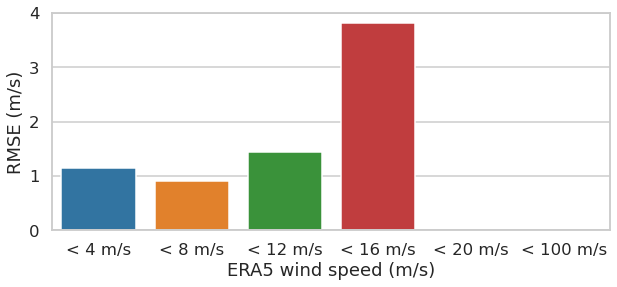

In [35]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
sns.barplot(data=df_rmse, x='bins', y='rmse', ax=ax)
ax.set_xlabel('ERA5 wind speed (m/s)')
ax.set_ylabel('RMSE (m/s)')

ax.set_xticks(range(len(y_bins)))
ax.set_xticklabels([f'< {yy} m/s' for yy in y_bins])

plt.show()

### Bar plot of the bias for different values of the windspeed

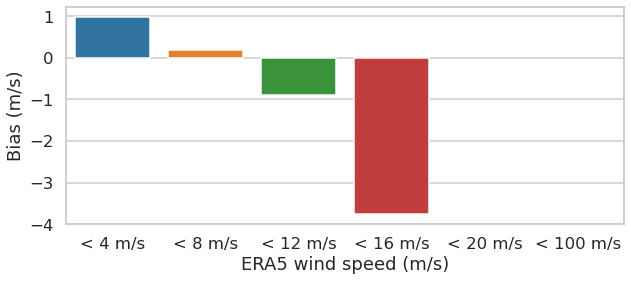

In [36]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
sns.barplot(data=df_rmse, x='bins', y='bias', ax=ax)
ax.set_xlabel('ERA5 wind speed (m/s)')
ax.set_ylabel('Bias (m/s)')

ax.set_xticks(range(len(y_bins)))
ax.set_xticklabels([f'< {yy} m/s' for yy in y_bins])

plt.show()